# American Sign Language Prediction

> This notebook is in association with the Unified Mentor Machine Learning internship project submission.

The task is to build a system that accepts an ASL input image and detects what the ASL input image represents.

This is an image classification task. We have to classify different ASL hand signs to what they repectively represent. We'll use Transfer Learning for this task, using the EfficientNetB0 model.

> Transfer Learning is a machine learning technique where a pretrained model, previously trained on similar data of our own, is used to train a new model for our specific task and accelerate the training process.

[*Visit Projects' Streamlit App*](https://american-sign-language-detector.streamlit.app/)

## 1. Downloading & Importing Libraries

In [ ]:
try:
    import kagglehub
except:
    !pip install kagglehub
    import kagglehub

# Download latest version
asl_path = kagglehub.dataset_download('grassknoted/asl-alphabet')

print('Data source import complete. Dataset path: ', asl_path)


100%|██████████| 1.03G/1.03G [00:15<00:00, 69.4MB/s]

Extracting files...


Data source import complete. Dataset path:  /root/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1


In [ ]:
!ls /root/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1

asl_alphabet_test  asl_alphabet_train


In [ ]:
# Train images folders.
!ls /root/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1/asl_alphabet_train/asl_alphabet_train

A  B  C  D  del  E  F  G  H  I	J  K  L  M  N  nothing	O  P  Q  R  S  space  T  U  V  W  X  Y	Z


In [ ]:
# Test images.
!ls /root/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1/asl_alphabet_test/asl_alphabet_test

A_test.jpg  E_test.jpg	I_test.jpg  M_test.jpg	      P_test.jpg      S_test.jpg  W_test.jpg
B_test.jpg  F_test.jpg	J_test.jpg  nothing_test.jpg  Q_test.jpg      T_test.jpg  X_test.jpg
C_test.jpg  G_test.jpg	K_test.jpg  N_test.jpg	      R_test.jpg      U_test.jpg  Y_test.jpg
D_test.jpg  H_test.jpg	L_test.jpg  O_test.jpg	      space_test.jpg  V_test.jpg  Z_test.jpg


In [ ]:
# installing packages.
! pip install icecream dagshub mlflow torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.0/254.0 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.4/27.4 MB 58.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 83.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 92.6 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 623.0/623.0 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: dacite
    Found existing installation: dacite 1.8.1
    Uninstalling dacite-1.8.1:
      Successfully uninstalled dacite-1.8.1
  Attempting uninstall: cachet

In [ ]:
# Importing libraries.
import mlflow
import dagshub
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision
import torch
import torchmetrics
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from typing import Dict, Any, Optional
from urllib.parse import urlparse
from icecream import ic
from rich.progress import track

import os
import pickle
import plotly
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
# pio.templates.default = "seaborn"
pio.renderers.default = "colab"


## 2. Data Loader Script

This is the `data_loader.py` script used to load the images, pytorch model, optimizer, and learning rate scheduler.

In [ ]:
%%writefile data_loader.py
import os
import torchvision
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from typing import Dict, List, Optional, Tuple
from dataclasses import dataclass, field
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler
from torch.utils.data.distributed import DistributedSampler
from sklearn.utils.class_weight import compute_class_weight

NUM_WORKERS = os.cpu_count()


def load_data_objs(
    batch_size: int,
    rank: int,
    world_size: int,
    epochs: int,
    x_train_path: str,
    gpu: bool,
    gpu_id: int,
    learning_rate: float,
    num_workers: int,
    lr_scheduler: Optional[str] = None,
) -> tuple[DataLoader, DataLoader, nn.Module, nn.CrossEntropyLoss, torch.optim.Optimizer, Optional[torch.optim.lr_scheduler._LRScheduler]]:
    # Loading DEFAULT = best available weights of EfficientNet_B0 model
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

    # Loading transform for transforming the images to be compatible with EfficientNet_B0 model
    auto_transforms = weights.transforms()
    torch.save(auto_transforms, "effnetb0_transform.pt")

    # Loading EfficientNet_B0 model
    model = torchvision.models.efficientnet_b0(weights=weights)

    # Use ImageFolder to create dataset(s)
    train_data = datasets.ImageFolder(x_train_path, transform=auto_transforms)
    torch.save(train_data, "train_data.pt")
    # val_data = datasets.ImageFolder(x_val_path, transform=auto_transforms)

    # Get class names
    class_names = train_data.classes
    torch.save(class_names, "class_names.pt")

    # Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
    for param in model.features.parameters():
        param.requires_grad = False

    # Recreate the classifier layer
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=1280, out_features=len(class_names), bias=True))

    optimizer = torch.optim.Adam(
        params=model.parameters(), lr=learning_rate, weight_decay=1e-4)

    criterion = nn.CrossEntropyLoss()

    if gpu:
        dist_sampler_train = DistributedSampler(
            train_data, num_replicas=world_size, rank=rank, seed=42)
        train_dtl = DataLoader(train_data, batch_size=batch_size, shuffle=False,
                               pin_memory=True, sampler=dist_sampler_train, num_workers=num_workers, )

        # dist_sampler_val = DistributedSampler(val_data, num_replicas=world_size, rank=rank, seed=42)
        # val_dtl = DataLoader(val_data, batch_size=1, shuffle=False, pin_memory=True, sampler=dist_sampler_val, num_workers=num_workers, )

    else:
        train_dtl = DataLoader(train_data, batch_size=batch_size,
                               shuffle=True, pin_memory=True, num_workers=num_workers, )

        # val_dtl = DataLoader(val_dts, batch_size=1, shuffle=False, pin_memory=True, num_workers=num_workers, )

    scheduler = None
    if lr_scheduler:
        LR_SCHEDULER = {
            # requires to set metric
            "reduce_lr": torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2),
            "one_cycle_lr": torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, epochs=epochs, steps_per_epoch=len(train_dtl), anneal_strategy='cos')
        }

        if lr_scheduler in LR_SCHEDULER:
            scheduler = LR_SCHEDULER[lr_scheduler]
        else:
            raise ValueError(f"""Invalid lr_scheduler value: {
                lr_scheduler}. Valid options are: {list(LR_SCHEDULER.keys())}""")
    return train_dtl, model, criterion, optimizer, scheduler


Writing data_loader.py


## 3. PyTorch Engine Script

This is the `pt_engine.py` script, used to train the the model and save model checkpoints.

In [ ]:
%%writefile pt_engine.py
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data import DataLoader
from typing import List, Dict, Optional
from rich.progress import track
from pathlib import Path
from icecream import ic
import torch.distributed as dist
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import random
import torchmetrics
import torch
import time
import os


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


def loss_metric_tensor(array: List[Dict[str, np.ndarray]]) -> torch.Tensor:
    all_tensors = [torch.tensor([[array[0][j][k] for k in range(
        len(array[0][j]))]], dtype=torch.float32) for j in array[0].keys()]
    b = torch.cat(all_tensors, dim=0)
    return b.transpose(0, 1)


class CustomTrainer:
    def __init__(
        self,
        model: nn.Module,
        train_data: DataLoader,
        # val_data: DataLoader,
        criterion: nn.CrossEntropyLoss,
        optimizer: torch.optim.Optimizer,
        gpu_id: int,
        save_path: str | Path,
        gpu: bool,
        patience: int = 5,
        max_epochs: int = 10,
        world_size: int = 1,
        scheduler: Optional[torch.optim.lr_scheduler._LRScheduler] = None
        ) -> None:
        self.model = model
        self.train_data = train_data
        # self.val_data = val_data
        self.criterion = criterion
        self.optimizer = optimizer
        self.gpu_id = gpu_id
        self.save_path = save_path
        self.gpu = gpu
        self.patience = patience
        self.max_epochs = max_epochs
        self.world_size = world_size
        self.scheduler = scheduler

        if self.gpu:
            self.model = DDP(self.model.to(self.gpu_id), device_ids=[self.gpu_id])
            self.train_losses_ = [{f'train_losses{i}': np.array([]) for i in range(self.world_size)}]
            # self.val_losses_ = [{f'val_losses{i}': np.array([]) for i in range(self.world_size)}]
            self.train_f1s_ = [{f'train_metrics{i}': np.array([]) for i in range(self.world_size)}]
            # self.val_f1s_ = [{f'val_metrics{i}': np.array([]) for i in range(self.world_size)}]
            self.train_accuracies_ = [{f'train_metrics{i}': np.array([]) for i in range(self.world_size)}]
            # self.val_accuracies_ = [{f'val_metrics{i}': np.array([]) for i in range(self.world_size)}]
            self.train_metric_accuracy = torchmetrics.classification.MulticlassAccuracy(num_classes=29, average="micro", sync_on_compute=False).to(self.gpu_id)
            self.train_metric_f1score = torchmetrics.classification.MulticlassF1Score(num_classes=29, average="macro", sync_on_compute=False).to(self.gpu_id)
            # self.val_metric_accuracy = torchmetrics.classification.BinaryAccuracy(sync_on_compute=False).to(self.gpu_id)
            # self.val_metric_f1score = torchmetrics.classification.BinaryF1Score(sync_on_compute=False).to(self.gpu_id)
        else:
            self.train_losses_ = [{"losses": np.array([])}]
            # self.val_losses_ = [{"losses": np.array([])}]
            self.train_f1s_ = [{"metrics": np.array([])}]
            # self.val_f1s_ = [{"metrics": np.array([])}]
            self.train_accuracies_ = [{"metrics": np.array([])}]
            # self.val_accuracies_ = [{"metrics": np.array([])}]
            self.train_metric_accuracy = torchmetrics.classification.MulticlassAccuracy(num_classes=29, average="micro")
            self.train_metric_f1score = torchmetrics.classification.MulticlassF1Score(num_classes=29, average="macro")
            # self.val_metric_accuracy = torchmetrics.classification.BinaryAccuracy()
            # self.val_metric_f1score = torchmetrics.classification.BinaryF1Score()


    def _run_batch(self, source: torch.Tensor, targets: torch.Tensor, pred_labels: np.ndarray) -> tuple[float]:
        source = source.to(self.gpu_id)
        targets = targets.to(self.gpu_id)

        self.model.train()
        self.optimizer.zero_grad()
        y_logits = self.model(source)
        preds = torch.softmax(y_logits, dim=1)
        preds = torch.argmax(preds, dim=1)
        loss = self.criterion(y_logits, targets)
        loss.backward()
        self.optimizer.step()

        pred_labels[0]['preds'].extend(preds.detach().cpu().numpy().tolist())
        pred_labels[0]['targets'].extend(targets.cpu().numpy().tolist())

        self.train_metric_accuracy.update(preds, targets)
        self.train_metric_f1score.update(preds, targets)

        return loss.item(), pred_labels


    def _run_epoch(self, epoch: int, total_epochs: int) -> tuple[float, float, float]:
        total_samples = len(self.train_data.dataset)
        num_batches = len(self.train_data)
        total_loss = 0
        total_accuracy = 0
        total_f1score = 0
        total_samples_ = 0

        if self.gpu:
            self.train_data.sampler.set_epoch(epoch)
            self.train_metric_accuracy.reset()
            self.train_metric_f1score.reset()

        pred_labels = np.array([{'targets': [], 'preds': []}])
        for source, targets in track(self.train_data,
                         description=f"""{f"[GPU{self.gpu_id}] " if self.gpu else ""}Epoch {epoch + 1}/{total_epochs} | Training: {num_batches} batches...""", style='red', complete_style='cyan', finished_style='green'):

            batch_size_ = source.size(0)  # Get batch size
            total_samples_ += batch_size_  # Accumulate total samples

            loss, pred_labels = self._run_batch(source, targets, pred_labels)
            total_loss += loss * batch_size_

        avg_loss = total_loss / total_samples_

        accuracy = self.train_metric_accuracy.compute()
        f1score = self.train_metric_f1score.compute()

        return avg_loss, accuracy.item(), f1score.item(), pred_labels


    def _save_checkpoint(self, loss: float, accuracy: float, f1score: float, pred_labels: np.ndarray) -> None:
        ckp = self.model.module.state_dict()
        ckp_path = f"{self.save_path}/best_model.pt"
        torch.save(ckp, ckp_path)
        np.save("loss_train.npy", loss, allow_pickle=True)
        np.save("accuracy_train.npy", accuracy, allow_pickle=True)
        np.save("f1score_train.npy", f1score, allow_pickle=True)
        np.save("pred_labels.npy", pred_labels, allow_pickle=True)

        if self.gpu:
            print(f"\t\tNew best model saved at {ckp_path} from GPU{self.gpu_id}.")
        else:
            print(f"\t\tNew best model save at {ckp_path}.")


    def gather_tensor(self, t: torch.Tensor) -> torch.Tensor:
        gathered_t = [torch.zeros_like(t) for _ in range(self.world_size)]
        torch.distributed.all_gather(gathered_t, t)
        return torch.cat(gathered_t, dim=0)


    def train(self) -> None:
        if self.gpu:
            should_stop = torch.zeros(1).to(self.gpu_id)
            patience_count = torch.zeros(1, dtype=torch.int32).to(self.gpu_id)

            # Gather losses from all GPUs
            train_losses = [torch.zeros(1).to(self.gpu_id)
                            for _ in range(self.world_size)]
            # val_losses = [torch.zeros(1).to(self.gpu_id)
                          # for _ in range(self.world_size)]
            train_f1s = [torch.zeros(1).to(self.gpu_id)
                         for _ in range(self.world_size)]
            # val_f1s = [torch.zeros(1).to(self.gpu_id)
            #            for _ in range(self.world_size)]
            train_accuracies = [torch.zeros(1).to(self.gpu_id)
                                for _ in range(self.world_size)]
            # val_accuracies = [torch.zeros(1).to(self.gpu_id)
            #                   for _ in range(self.world_size)]
            train_losses_t = torch.empty(0).to(self.gpu_id)
            train_metrics_t = torch.empty(0).to(self.gpu_id)
        else:
            should_stop = torch.zeros(1)
            patience_count = torch.zeros(1, dtype=torch.int32)
            train_losses = []
            # val_losses = []
            train_f1s = []
            # val_f1s = []
            train_accuracies = []
            # val_accuracies = []
            train_losses_t = []
            train_metrics_t = []

        set_seed(42)
        for epoch in range(self.max_epochs):
            train_loss, train_accuracy, train_f1, pred_labels = self._run_epoch(epoch, self.max_epochs)

            print(
                f"""\t{f"[GPU{self.gpu_id}] | " if self.gpu else ""}Batches: {len(self.train_data)} per GPU | train_loss: {train_loss:.4f} | train_accuracy: {train_accuracy:.4f} | train_f1: {train_f1:.4f} | Learning Rate: {self.optimizer.param_groups[0]['lr']:.6f}""")

            if self.scheduler is not None:
                self.scheduler.step(val_loss)

            ic(pred_labels[0]['targets'][-6:], pred_labels[0]['preds'][-6:])

            # Save losses for all GPUs
            if self.gpu:
                try:
                    torch.distributed.all_gather(
                        train_losses, torch.tensor([train_loss]).to(self.gpu_id))
                    torch.distributed.all_gather(
                        train_f1s, torch.tensor([train_f1]).to(self.gpu_id))
                    torch.distributed.all_gather(
                        train_accuracies, torch.tensor([train_accuracy]).to(self.gpu_id))
                except RuntimeError as e:
                    print(f"Error gathering losses: {e}")
                    break

                for i in range(self.world_size):
                    self.train_losses_[0][f"train_losses{i}"] = np.append(
                        self.train_losses_[0][f"train_losses{i}"], train_losses[i].item())
                    self.train_f1s_[0][f"train_metrics{i}"] = np.append(
                        self.train_f1s_[0][f"train_metrics{i}"], train_f1s[i].item())
                    self.train_accuracies_[0][f"train_metrics{i}"] = np.append(
                        self.train_accuracies_[0][f"train_metrics{i}"], train_accuracies[i].item())

                train_losses_t = loss_metric_tensor(self.train_losses_)
                train_metrics_t = loss_metric_tensor(self.train_f1s_)

                train_losses_last_item = np.min(train_losses_t[-1:].squeeze().numpy())
                train_metrics_last_item = np.max(train_metrics_t[-1:].squeeze().numpy())
                bval_loss = np.min(train_losses_t.numpy())
                bval_metric = np.max(train_metrics_t.numpy())

                improved = torch.tensor([False], dtype=torch.bool).to(self.gpu_id)
            else:
                self.train_losses_[0]["losses"] = np.append(self.train_losses_[0]["losses"], train_losses)
                self.train_f1s_[0]["metrics"] = np.append(self.train_f1_s[0]["metrics"], train_f1s)
                self.train_accuracies_[0]["metrics"] = np.append(self.train_accuracies_[0]["metrics"], train_accuracies)

                train_losses_last_item = self.train_losses_[0]["losses"][-1]
                train_metrics_last_item = self.train_f1s_[0]["metrics"][-1]
                bval_loss = np.min(self.train_losses_)
                bval_metric = np.max(self.train_f1s_)
                improved = torch.tensor([False], dtype=torch.bool)

            if self.gpu:
                if (len(torch.where(train_losses_t == train_losses_last_item)[1]) == 1) and (
                        len(torch.where(train_metrics_t == train_metrics_last_item)[1]) == 1):
                    train_losses_last_gpu = torch.where(
                        train_losses_t == train_losses_last_item)[1].item()
                    train_metrics_last_gpu = torch.where(
                        train_metrics_t == train_metrics_last_item)[1].item()
                    train_losses_last_gpu_row = torch.where(
                        train_losses_t == train_losses_last_item)[0].item()
                    train_metrics_last_gpu_row = torch.where(
                        train_metrics_t == train_metrics_last_item)[0].item()

                    train_losses_last_metric = train_metrics_t[train_losses_last_gpu_row, train_losses_last_gpu]
                    train_metrics_last_loss = train_losses_t[train_metrics_last_gpu_row, train_metrics_last_gpu]

                    if (train_losses_last_item == bval_loss) and (train_metrics_last_item == bval_metric) and (
                            train_losses_last_gpu == train_metrics_last_gpu) and (self.gpu_id == train_losses_last_gpu):
                        print(f"""\t\t1/1:[GPU{self.gpu_id}] train_loss improved to {
                        train_losses_last_item:.4f} | train_f1score improved to {train_metrics_last_item:.4f}""")
                        self._save_checkpoint(train_loss, train_accuracy, train_f1, pred_labels)

                        improved = torch.tensor([True], dtype=torch.bool).to(self.gpu_id)

                        time.sleep(2)
                    elif (train_losses_last_item == bval_loss) and (train_metrics_last_item == bval_metric) and (
                            train_losses_last_gpu != train_metrics_last_gpu) and (self.gpu_id == train_losses_last_gpu):
                        print(f"""\t\t1/2:[GPU{self.gpu_id}] train_loss improved to {
                        train_losses_last_item:.4f} | train_f1score: {train_losses_last_metric:.4f}""")
                        self._save_checkpoint(train_loss, train_accuracy, train_f1, pred_labels)

                        improved = torch.tensor([True], dtype=torch.bool).to(self.gpu_id)

                        time.sleep(2)
                    elif (train_losses_last_item == bval_loss) and (self.gpu_id == train_losses_last_gpu):
                        print(f"""\t\t1/3:[GPU{self.gpu_id}] train_loss improved to {
                        train_losses_last_item:.4f} | train_f1score: {train_losses_last_metric:.4f}""")
                        self._save_checkpoint(train_loss, train_accuracy, train_f1, pred_labels)

                        improved = torch.tensor([True], dtype=torch.bool).to(self.gpu_id)

                        time.sleep(2)
                    elif (train_metrics_last_item == bval_metric) and (self.gpu_id == train_metrics_last_gpu):
                        print(f"""\t\t1/4[GPU{self.gpu_id}] train_loss: {
                        train_metrics_last_loss:.4f} | train_f1score improved to {train_metrics_last_item:.4f}""")
                        self._save_checkpoint(train_loss, train_accuracy, train_f1, pred_labels)

                        improved = torch.tensor([True], dtype=torch.bool).to(self.gpu_id)

                        time.sleep(2)
                elif (len(torch.where(train_losses_t == train_losses_last_item)[1]) == 1) and (
                        len(torch.where(train_metrics_t == train_metrics_last_item)[1]) > 1):
                    train_losses_last_gpu = torch.where(
                        train_losses_t == train_losses_last_item)[1].item()
                    train_losses_last_gpu_row = torch.where(
                        train_losses_t == train_losses_last_item)[0].item()
                    train_losses_last_metric = train_metrics_t[train_losses_last_gpu_row, train_losses_last_gpu]

                    if (train_losses_last_item == bval_loss) and (self.gpu_id == train_losses_last_gpu):
                        print(f"""\t\t3:[GPU{self.gpu_id}] train_loss improved to {
                        train_losses_last_item:.4f} | train_f1score: {train_losses_last_metric:.4f}""")
                        self._save_checkpoint(train_loss, train_accuracy, train_f1, pred_labels)

                        improved = torch.tensor([True], dtype=torch.bool).to(self.gpu_id)

                        time.sleep(2)
                else:
                    pass
            else:
                if (train_losses_last_item == bval_loss) and (train_metrics_last_item == bval_metric):
                    print(f"""\t\t1:train_loss improved to {
                    train_losses_last_item:.4f} | train_f1score improved to {train_metrics_last_item:.4f}""")
                    self._save_checkpoint(train_loss, train_accuracy, train_f1, pred_labels)

                    improved = torch.tensor([True], dtype=torch.bool)

                    time.sleep(2)
                elif train_losses_last_item == bval_loss:
                    print(f"""\t\t2:train_loss improved to {
                    train_losses_last_item:.4f} | train_f1score: {train_metrics_last_item:.4f}""")
                    self._save_checkpoint(train_loss, train_accuracy, train_f1, pred_labels)

                    improved = torch.tensor([True], dtype=torch.bool)

                    time.sleep(2)
                elif train_metrics_last_item == bval_metric:
                    print(f"""\t\t3:train_loss: {
                    train_losses_last_item:.4f} | train_f1score improved to {train_metrics_last_item:.4f}""")
                    self._save_checkpoint(train_loss, train_accuracy, train_f1, pred_labels)

                    improved = torch.tensor([True], dtype=torch.bool)

                    time.sleep(2)
                else:
                    pass

            if self.gpu
                # Synchronize patience count across all GPU
                improved_state = self.gather_tensor(improved

                # Update patience count
                if self.world_size == 1:
                    if improved_state:
                        patience_count.zero_()
                    else:
                        patience_count += 1
                else:
                    if (improved_state[0] and improved_state[1]) or (improved_state[0] or improved_state[1]):
                        patience_count.zero_()
                    else:
                        patience_count += 1

                # Synchronize patience count across all GPUs
                all_patience_counts = self.gather_tensor(patience_count)
                max_patience_count = torch.max(all_patience_counts).item()
                patience_count.fill_(max_patience_count)

                if max_patience_count >= self.patience:
                    print(
                        f"\n[GPU{self.gpu_id}] Patience exceeded. Early stopping...")
                    should_stop[0] = 1

                # Synchronize the should_stop tensor across all GPUs
                should_stop_list = [torch.zeros(1).to(
                    self.gpu_id) for _ in range(self.world_size)]
                torch.distributed.all_gather(should_stop_list, should_stop)

                # If any GPU wants to stop, all GPUs should stop
                if any(_stop.item() for _stop in should_stop_list):
                    break
            else:
                if improved:
                    patience_count.zero_()
                else:
                    patience_count += 1

                    if patience_count >= self.patience:
                        print(f"\nPatience exceeded. Early stopping...")
                        break

            time.sleep(2)

        if self.gpu:
            # Ensure all GPUs exit the training loop together
            dist.barrier()

            if self.gpu_id == 0:
                np.save("train_losses.npy", self.train_losses_, allow_pickle=True)
                np.save("train_f1s.npy", self.train_f1s_, allow_pickle=True)
                np.save("train_accuracies.npy", self.train_accuracies_, allow_pickle=True)
        else:
            np.save("train_losses.npy", self.train_losses_, allow_pickle=True)
            np.save("train_f1s.npy", self.train_f1s_, allow_pickle=True)
            np.save("train_accuracies.npy", self.train_accuracies_, allow_pickle=True)

Writing pt_engine.py


## 4. Train Script

This the `pt_train.py` script, used to accept training arguments and run the `pt_engine.py` script.

In [ ]:
%%writefile pt_train.py
from torch.distributed import init_process_group, destroy_process_group
from pt_engine import CustomTrainer
from data_loader import load_data_objs
from typing import Optional
from pathlib import Path
import torch.multiprocessing as mp
import torch.distributed as dist
import numpy as np
import argparse
import random
import torch
import time
import os


NUM_WORKERS = os.cpu_count()


def find_free_port():
    """Finds a free port."""
    import socket
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.bind(('', 0))  # Bind to port 0 to get a free port
        print("Got free port...")
        return s.getsockname()[1]


def ddp_setup(rank: int, world_size: int) -> None:
    """
    Args:
        rank: Unique identifier of each process
        world_size: Total number of processes
    """
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '12355'
    print("Init. process group...")
    dist.init_process_group("nccl", rank=rank, world_size=world_size)
    torch.cuda.set_device(rank)


def cleanup():
    dist.destroy_process_group()


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


def main(rank: Optional[int], world_size: Optional[int], total_epochs: int, patience: int, batch_size: int, save_path: str | Path, xtrain_path: str, learning_rate: float, lr_scheduler: str, gpu: bool) -> None:
    if gpu:
        # if rank == 0:
        print(f"{'>' * 10}BinaryClassifier Model Training{'<' * 10}\n")
        ddp_setup(rank, world_size)
        print("Initializing dataset and model...")
        train_dtl, model, criterion, optimizer, scheduler = load_data_objs(
            batch_size, rank, world_size, total_epochs, xtrain_path, gpu, rank,
            learning_rate, NUM_WORKERS, lr_scheduler)
        print("Created dataset and initialized model...")
        trainer = CustomTrainer(model=model, train_data=train_dtl, criterion=criterion, optimizer=optimizer, gpu_id=rank, save_path=save_path, gpu=gpu, patience=patience, max_epochs=total_epochs, world_size=world_size, scheduler=scheduler)
        print("Starting model training...")
        trainer.train()
        # destroy_process_group()
        cleanup()
        print(f"\n<{'=' * 10}Training completed & best model saved{'=' * 10}>\nExiting...")
    else:
        print(f"{'>' * 10}BinaryClassifier Model Training{'<' * 10}\n")
        train_dtl, val_dtl, model, criterion, optimizer, scheduler = load_data_objs(
            batch_size, rank, world_size, total_epochs, xtrain_path, gpu, rank,
            learning_rate, NUM_WORKERS, lr_scheduler)
        trainer = CustomTrainer(model=model, train_data=train_dtl, criterion=criterion, optimizer=optimizer, gpu_id=rank, save_path=save_path, gpu=gpu, patience=patience, max_epochs=total_epochs, world_size=world_size, scheduler=scheduler)
        trainer.train()
        print(f"\n<{'=' * 10}Training completed & best model saved{'=' * 10}>\nExiting...")


def create_model_path(path_str: str) -> Path | None:
    try:
        model_path = Path(path_str)
        model_path.mkdir(parents=True, exist_ok=True)

        # Check if the directory is writable
        if not os.access(model_path, os.W_OK):
            raise PermissionError(f"The directory {model_path} is not writable.")

        return model_path

    except PermissionError as e:
        print(f"Permission error: {e}")
        return None

    except OSError as e:
        print(f"OS error occurred when creating directory: {e}")
        return None

    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None


def exec_time(st: float, et: float) -> None:
    hour = int(et-st)//3600
    minute = int((et-st)%3600)//60
    second = int(et-st)%60
    print(f'\nexec time => {hour:02d}hr : {minute:02d}min : {second:02d}sec')


if __name__ == "__main__":
    os.environ['NOTEBOOKAPP_IOPUB_MSG_RATE_LIMIT'] = '10000.0'
    os.environ['NOTEBOOKAPP_RATE_LIMIT_WINDOW'] = '10.0'
    os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
    parser = argparse.ArgumentParser(description='simple distributed training job')
    parser.add_argument('--total_epochs', default=10, type=int,
                        help='Total epochs to train the model (default: 10)')

    parser.add_argument('--patience', default=5, type=int,
                        help='Patience for increasing val_loss (default: 5)')
    parser.add_argument('--batch_size', default=32, type=int,
                        help='Input batch size on each device (default: 32)')
    parser.add_argument('--model_save_path', default='./checkpoints', type=str,
                        help='Path to save the best model (default: ./checkpoints)')
    parser.add_argument('--xtrain_path', default='X_train.npy', type=str,
                        help='Path to X_train pytorch tensor (default: X_train.npy)')
    parser.add_argument('--learning_rate', default=0.001, type=float,
                        help='Select learning rate (default: 0.001)')
    parser.add_argument('--lr_scheduler', default=None, type=str,
                        help='Select learning rate scheduler (default: None)')
    parser.add_argument('--world_size', default=None, type=int,
                       help='Pass the number of GPUs to be used for training (default: None(all))')
    parser.add_argument('--gpu', action='store_true', help='Train on GPU (default)')
    parser.add_argument('--no-gpu', dest='gpu', action='store_false', help='Train on CPU')
    parser.set_defaults(gpu=True)
    args = parser.parse_args()

    MODEL_PATH = create_model_path(args.model_save_path)

    if MODEL_PATH is None:
        print("Failed to create model path. Exiting program.")
        exit(1)

    if args.gpu:
        if args.world_size == None:
            world_size = torch.cuda.device_count()
        else:
            world_size = args.world_size

        # Set the start method to 'forkserver'
        mp.set_start_method('forkserver', force=True)

        set_seed(42)

        start_time = time.time()
        mp.spawn(main,
                 args=(world_size, args.total_epochs, args.patience, args.batch_size, MODEL_PATH, args.xtrain_path,
                       args.learning_rate, args.lr_scheduler, args.gpu), nprocs=world_size, join=True)
        end_time = time.time()
        exec_time(start_time, end_time)
    else:
        start_time = time.time()
        set_seed(42)
        main(None, None, args.total_epochs, args.patience, args.batch_size, MODEL_PATH, args.xtrain_path,
             args.learning_rate, args.lr_scheduler, args.gpu)
        end_time = time.time()
        exec_time(start_time, end_time)

Writing pt_train.py


## 5. Start Training

In [ ]:
!python pt_train.py --total_epochs 10 --batch_size 64 --gpu --xtrain_path /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train --learning_rate 0.001 --world_size 1

>>>>>>>>>>BinaryClassifier Model Training<<<<<<<<<<

Init. process group...
[W1218 15:20:37.383308617 CUDAAllocatorConfig.h:28] Warning: expandable_segments not supported on this platform (function operator())
Initializing dataset and model...
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|███████████████████████████████████████| 20.5M/20.5M [00:00<00:00, 126MB/s]
Created dataset and initialized model...
Starting model training...
[GPU0] Epoch 1/10 | Training: 1360 batches... ━━━━━━━━━━━━━━━━━━━━━ 100% 0:04:2600:0100:13
	[GPU0] | Batches: 1360 per GPU | train_loss: 0.6285 | train_accuracy: 0.8814 | train_f1: 0.8810 | Learning Rate: 0.001000
ic| pred_labels[0]['targets'][-6:]: [7, 16, 27, 10, 12, 13]
    pred_labels[0]['preds'][-6:]: [7, 16, 27, 10, 12, 13]
		1/1:[GPU0] train_loss improved to 0.6285 | train_f1score improved to 0.8810
		New best model saved at chec

## 6. Model Evaluation

In [ ]:
# Function for saving plotly plots as html to embed them later
with open('html_template.html', 'w') as f:
  f.write("""
  <!doctype html>
  <html>
  <head>
  <meta charset="utf-8" />
  <meta name="viewport" content="width=device-width, initial-scale=1.0" />
  </head>

  <body>
  <!-- <h3>{{ heading }}</h3> -->
  {{ fig }}
  </body>
  </head>
  """)

# Function to save plotly plots as html
def fig_to_html(fig: plotly.graph_objs._figure.Figure,
                # plot_heading: str,
                output_path: Optional[str]="output.html",
                template_path: Optional[str]="html_template.html") -> None:
  """

  Convert a plotly figure to an HTML.

  """

  # Create output directory if it doesn't exist
  output_dir = "plotly_html"
  os.makedirs(output_dir, exist_ok=True)

  from jinja2 import Template

  # Convert the figure to HTML
  plotly_jinja_data = {
      "fig": fig.to_html(full_html=False, include_plotlyjs="cdn"),
      # "heading": plot_heading
      }

  # Load the template
  with open(os.path.join(output_dir, output_path), "w", encoding="utf-8") as f:
    with open(template_path, "r", encoding="utf-8") as template_file:
      template = Template(template_file.read())
      f.write(template.render(plotly_jinja_data))

In [ ]:
# Preparing data for plotting epochs vs metrics curve.
tl_data = pd.DataFrame(np.load('train_losses.npy', allow_pickle=True).item())
ta_data = pd.DataFrame(np.load('train_accuracies.npy', allow_pickle=True).item())
tf1_data = pd.DataFrame(np.load('train_f1s.npy', allow_pickle=True).item())
tl_data['epochs'] = np.arange(1, len(tl_data)+1)
ta_data['epochs'] = np.arange(1, len(ta_data)+1)
tf1_data['epochs'] = np.arange(1, len(tf1_data)+1)

# Plotting curve.
if len(tl_data.columns) > 3:
    fig1 = px.line(data_frame=tl_data, x='epochs', y=['train_losses0'], height=750, width=750, title='Loss Curves: GPU0')
    fig1.update_xaxes(title_text='Epoch',)
    fig1.update_yaxes(title_text='Loss')
    fig_to_html(fig1, 'loss_curve_g0.html')
    fig1.show()
    fig2 = px.line(data_frame=tl_data, x='epochs', y=['train_losses1'], height=750, width=750, title='Loss Curves: GPU1')
    fig2.update_xaxes(title_text='Epoch',)
    fig2.update_yaxes(title_text='Loss')
    fig_to_html(fig2, 'loss_curve_g1.html')
    fig2.show()
    fig3 = px.line(data_frame=ta_data, x='epochs', y=['train_metrics0'], height=750, width=750, title='Accuracy Curves: GPU0')
    fig3.update_xaxes(title_text='Epoch',)
    fig3.update_yaxes(title_text='Accuracy')
    fig_to_html(fig3, 'accuracy_curve_g0.html')
    fig3.show()
    fig4 = px.line(data_frame=ta_data, x='epochs', y=['train_metrics1'], height=750, width=750, title='Accuracy Curves: GPU1')
    fig4.update_xaxes(title_text='Epoch',)
    fig4.update_yaxes(title_text='Accuracy')
    fig_to_html(fig4, 'accuracy_curve_g1.html')
    fig4.show()
    fig5 = px.line(data_frame=tf1_data, x='epochs', y=['train_metrics0'], height=750, width=750, title='F1Score Curves: GPU0')
    fig5.update_xaxes(title_text='Epoch',)
    fig5.update_yaxes(title_text='F1Score')
    fig_to_html(fig5, 'f1score_curve_g0.html')
    fig5.show()
    fig6 = px.line(data_frame=tf1_data, x='epochs', y=['train_metrics1'], height=750, width=750, title='F1Score Curves: GPU1')
    fig6.update_xaxes(title_text='Epoch',)
    fig6.update_yaxes(title_text='F1Score')
    fig_to_html(fig6, 'f1score_curve_g1.html')
    fig6.show()
    # fig1.show(), fig2.show(), fig3.show(), fig4.show(), fig5.show(), fig6.show()
elif len(tl_data.columns == 3) and 'train_losses1' not in tl_data.columns:
    fig1 = px.line(data_frame=tl_data, x='epochs', y=['train_losses0'], height=750, width=750, title='Loss Curves')
    fig1.update_xaxes(title_text='Epoch',)
    fig1.update_yaxes(title_text='Loss')
    fig_to_html(fig1, 'loss_curve.html')
    fig2 = px.line(data_frame=ta_data, x='epochs', y=['train_metrics0'], height=750, width=750, title='Accuracy Curves')
    fig2.update_xaxes(title_text='Epoch',)
    fig2.update_yaxes(title_text='Accuracy')
    fig_to_html(fig2, 'accuracy_curve.html')
    fig3 = px.line(data_frame=tf1_data, x='epochs', y=['train_metrics0'], height=750, width=750, title='F1Score Curves')
    fig3.update_xaxes(title_text='Epoch',)
    fig3.update_yaxes(title_text='F1Score')
    fig_to_html(fig3, 'f1score_curve.html')
    fig1.show(), fig2.show(), fig3.show()
else:
    fig1 = px.line(data_frame=tl_data, x='epochs', y=['train_losses'], height=750, width=750, title='Loss Curves')
    fig1.update_xaxes(title_text='Epoch',)
    fig1.update_yaxes(title_text='Loss')
    fig_to_html(fig1, 'loss_curve.html')
    fig2 = px.line(data_frame=ta_data, x='epochs', y=['train_metrics'], height=750, width=750, title='Accuracy Curves')
    fig2.update_xaxes(title_text='Epoch',)
    fig2.update_yaxes(title_text='Accuracy')
    fig_to_html(fig2, 'accuracy_curve.html')
    fig3 = px.line(data_frame=tf1_data, x='epochs', y=['train_metrics'], height=750, width=750, title='F1Score Curves')
    fig3.update_xaxes(title_text='Epoch',)
    fig3.update_yaxes(title_text='F1Score')
    fig_to_html(fig3, 'f1score_curve.html')
    fig1.show(), fig2.show(), fig3.show()

1. **Loss Curve:** The loss curve for GPU0 rapidly decreases during the initial epochs, this rapid decrease indicates that the model is learning the patterns and relationships in the training data quickly and effectively, indicating quick convergence. The curve starts flattening after epoch 6, indicating that there is little to no improvement happening in model performance. This flattening of the curve suggests that the model has reached a point where further training may not significantly reduce the training error.

2. **Accuracy Curve:** The accuracy increases rapidly, indicating that the model is learning the patterns of the training data well. The accuracy curve almost plateaus around epoch 6, which suggests that the model's performance on the training data has stabilized, consistent with the observation of the loss curve.

3. **F1 Score Curve:** The F1-score curve for GPU0 exhibits a trend similar to the accuracy curve, showing increasing scores rapidly in the initial epochs, and flattening out around epoch 6. This indicates that the model's overall performance, taking into account both precision and recall, is improving initially and the flattening of the F1-score curve suggests that the model's performance on the training data has stabilized and is in line with the observations from the loss and accuracy curves.

In [ ]:
pred_labels = np.load('pred_labels.npy', allow_pickle=True)

ic(pred_labels[0]['targets'][:10], pred_labels[0]['preds'][:10]);

ic| pred_labels[0]['targets'][:10]: [2, 21, 11, 0, 9, 16, 7, 9, 27, 26]
    pred_labels[0]['preds'][:10]: [2, 21, 11, 0, 9, 16, 7, 9, 27, 26]


In [ ]:
print(f"Classification Report:\n\n{classification_report(np.array(pred_labels[0]['targets']), np.array(pred_labels[0]['preds']), target_names=class_names)}")

Classification Report:

              precision    recall  f1-score   support

           A       0.97      0.97      0.97      3000
           B       0.98      0.98      0.98      3000
           C       0.99      0.99      0.99      3000
           D       0.99      0.99      0.99      3000
           E       0.97      0.97      0.97      3000
           F       0.99      0.99      0.99      3000
           G       0.98      0.97      0.98      3000
           H       0.98      0.98      0.98      3000
           I       0.96      0.96      0.96      3000
           J       0.98      0.97      0.98      3000
           K       0.97      0.97      0.97      3000
           L       0.99      0.98      0.99      3000
           M       0.95      0.95      0.95      3000
           N       0.96      0.96      0.96      3000
           O       0.99      0.99      0.99      3000
           P       0.98      0.98      0.98      3000
           Q       0.98      0.98      0.98      3000
   

The classification report provides precision, recall, and F1-score for each individual class.

1. **Precision:** Precision is the fraction of correctly classified instances among all instances classified as belonging to a particular class. Higher precision values indicate that the model is making fewer false positive predictions for that class. It can be seen that the values are generally higher than 0.90, indicating good performance.
2. **Recall:** Recall is the fraction of correctly classified instances among all instances that actually belong to a particular class. Higher recall values indicate that the model is making fewer false negative predictions for that class. These are also above 0.90, indicating good performance.
3. **F1-score:** The F1-score is a harmonic mean of precision and recall. It is a good overall measure of the model's performance for a particular class. The F1-scores are above 0.90, indicating good overall performance per class.

**Observations:** The model performs well on most classes, with high precision, recall, and F1-score values for most classes. This suggests that the model is able to accurately classify those classes in the training dataset.
Lower values of precision, recall and F1-score for some classes suggest the need to inspect those classes further, as the model may have some difficulty recognizing patterns related to those classes in the training data. There are a couple of classes for which this is the case in the provided classification report.
The results highlight the overall effectiveness of the model in accurately classifying images of sign language letters, with room for potential improvements for certain letter classification using additional training or data augmentation techniques.
The high accuracy and relatively balanced scores across classes in the classification report indicate a robust model with good generalization capabilities, making it suitable for detecting different classes of input images.

In [ ]:
# Plot Confusion Matrix.

def plot_confusion_matrix(y_test: np.ndarray, y_preds: np.ndarray, plot_name: str) -> None:
    """Plot confusion matrix."""

    cm = confusion_matrix(y_test, y_preds)

    fig = px.imshow(
        cm,
        text_auto=True,  # Display values on the heatmap
        labels=dict(x="Predicted", y="True"),  # Set axis labels
        x=class_names,  # Update x-axis labels
        y=class_names,  # Update y-axis labels
        color_continuous_scale="Blues",  # Customize the color scale
        width=920,
        height=920
    )

    fig.update_layout(title=f"Confusion Matrix")  # Set plot title
    fig_to_html(fig, f"{plot_name}")
    fig.show()  # Display plot

plot_confusion_matrix(np.array(pred_labels[0]['targets']), np.array(pred_labels[0]['preds']), "confusion_matrix.html")

In [ ]:
# Plotting Precision-Recall Curve
def plot_precision_recall_curve(y_test: np.ndarray, y_preds: np.ndarray, plot_name: str) -> None:
    """Plot precision-recall curve."""

    import plotly.graph_objects as go
    from sklearn.metrics import precision_recall_curve, average_precision_score
    from sklearn.preprocessing import label_binarize

    # Assuming you have 'y_test' (true labels) and 'y_preds' (predicted labels)

    # 1. Binarize the labels
    n_classes = len(class_names)  # Get the number of classes
    y_test_bin = label_binarize(y_test, classes=range(n_classes))
    y_preds_bin = label_binarize(y_preds, classes=range(n_classes))

    # 2. Create the Plotly figure
    fig = go.Figure()

    # 3. Calculate and plot precision-recall curves for each class
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_preds_bin[:, i])
        avg_precision = average_precision_score(y_test_bin[:, i], y_preds_bin[:, i])

        fig.add_trace(go.Scatter(
            x=recall,
            y=precision,
            mode='lines',
            name=f"Class {i} (Avg Precision: {avg_precision:.2f})"
        ))

    # 4. Update layout for better visualization
    fig.update_layout(
        title=f"Precision-Recall Curve",
        xaxis_title="Recall",
        yaxis_title="Precision",
        xaxis_range=[0, 1],
        yaxis_range=[0, 1],
        showlegend=True
    )

    fig_to_html(fig, f"{plot_name}")

    fig.show()  # Display plot

plot_precision_recall_curve(np.array(pred_labels[0]['targets']), np.array(pred_labels[0]['preds']), "pr_curve.html")

In [ ]:
# Plotting ROC Curve
def plot_roc_curve(y_test: np.ndarray, y_preds: np.ndarray, plot_name: str) -> None:
    import plotly.graph_objects as go
    from sklearn.metrics import roc_curve, auc, roc_auc_score
    from sklearn.preprocessing import label_binarize
    """Plots the ROC curve."""

    # 1. Binarize the labels.
    n_classes = len(class_names)  # Get the number of classes
    y_test_bin = label_binarize(y_test, classes=range(n_classes))
    y_preds_bin = label_binarize(y_preds, classes=range(n_classes))

    # 2. Create the figure.
    fig = go.Figure()

    # 3. Calculate the fpr and tpr.
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_preds_bin[:, i])
        roc_auc = auc(fpr, tpr)

        fig.add_trace(go.Scatter(
            x=fpr,
            y=tpr,
            mode='lines',
            name=f"Class {i} (AUC = {roc_auc:.2f})"
        ))

    # 4. Update the plot.
    fig.update_layout(
        title=f"ROC Curve",
        xaxis_title="False Positive Rate",
        yaxis_title="True Positive Rate",
        xaxis_range=[0, 1],
        yaxis_range=[0, 1],
        showlegend=True
    )

    fig_to_html(fig, f"{plot_name}")

    fig.show()  # Display

plot_roc_curve(np.array(pred_labels[0]['targets']), np.array(pred_labels[0]['preds']), "roc_curve.html")

## 7. Logging Experiment to DAGHub mlflow.

In [ ]:
!dagshub login

                      ❗❗❗ AUTHORIZATION REQUIRED ❗❗❗                      


Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=ca66121b-fc6c-4344-93ea-e770f4f72058&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=929c237866c9a6dc198a2708f0027f3aaec229d6f82e195328e5d71aa5cfea3c


⠋[?25l⠋ Waiting for authorization Waiting for authorization Waiting for authorization Waiting for authorization Waiting for authorization Waiting for authorization Waiting for authorization Waiting for authorization Waiting for authorization Waiting for authorization Waiting for authorization Waiting for authorization Waiting for authorization Waiting for authorization Waiting for authorization Waiting for authorization Waiting for authorization Waiting for authorization Waiting for authorization Waiting for authorization Waiting for authorization Waiting for authorization Waiting for authorization Wait

In [ ]:
from google.colab import userdata
repo_owner_ = userdata.get('REPO_OWNER')
repo_name_ = userdata.get('REPO_NAME')
tracking_uri = userdata.get('MLFLOW_TRACKING_URI')

# from kaggle_secrets import UserSecretsClient
# repo_owner_ = UserSecretsClient().get_secret("REPO_OWNER")
# repo_name_ = UserSecretsClient().get_secret("REPO_NAME")
# tracking_uri = UserSecretsClient().get_secret("MLFLOW_TRACKING_URI")


os.makedirs('tmp', exist_ok=True)

# Creating function to log experiments to mlflow
def create_experiment(experiment_name: str,run_name: str, run_metrics: Dict[str, Any], model: nn.Module, model_name: Optional[str] = None, artifact_paths: Dict[str, str] = {}, run_params: Optional[Dict[str, Any]] = None, tag_dict: Dict[str, str] = {"tag1":"Binary Classification", "tag2":"Patient Survival Prediction", "tag3": "PyTorch"}):
    try:
        dagshub.init(repo_owner=f"{repo_owner_}", repo_name=f"{repo_name_}", mlflow=True)

        # You can get your MLlfow tracking uri from your dagshub repo by opening "Remote" dropdown menu, go to "Experiments" tab and copy the MLflow experiment tracking uri and paste below

        mlflow.set_tracking_uri(f"{tracking_uri}")

        mlflow.set_experiment(experiment_name)

        with mlflow.start_run(run_name=run_name):

            # log params
            if run_params:
                for param in run_params:
                    mlflow.log_param(param, run_params[param])

            # log metrics
            for metric, value in run_metrics.items():
                if isinstance(value, list):

                    # If the metric is a list, log each value as a separate step
                    for step, v in enumerate(value):
                        mlflow.log_metric(metric, v, step=step)
                elif isinstance(value, str):
                    value = np.load(value, allow_pickle=True)
                    mlflow.log_metric(metric, value)
                else:

                    # If it's a single value, log it normally
                    mlflow.log_metric(metric, value)

            tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

            # log artifacts
            for artifact_name, path in artifact_paths.items():
                if path and os.path.exists(path):
                    if tracking_url_type_store != "file":
                        mlflow.log_artifact(
                            path,
                            # artifact_name
                        )

                elif path:
                    print(f"Warning: Artifact file not found: {path}")

            # log model
            if tracking_url_type_store != "file":
                mlflow.pytorch.log_model(model, "pytorch_model")

            mlflow.set_tags(tag_dict)

        print(f'Run - {run_name} is logged to Experiment - {experiment_name}')
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        import traceback
        traceback.print_exc()

In [ ]:
# Logging Experiment
from datetime import datetime
experiment_name = "asl_pytorch_transfer_learning"
run_name = "run_"+str(datetime.now().strftime("%d-%m-%y_%H:%M:%S"))

run_params = {"epochs": 10, "batch_size": 64, "learning_rate": 0.001, "image_size": 224, "gpu": True, "lr_scheduler": None}

run_metrics = {"train_accuracy": "accuracy_train.npy", "train_f1score": "f1score_train.npy", "train_loss": "loss_train.npy"}

plotly_path = "/kaggle/working/plotly_html"
artifact_paths = {"loss_curve": os.path.join(plotly_path, "loss_curve.html"), "accuracy_curve": os.path.join(plotly_path, "accuracy_curve.html"), "f1score_curve": os.path.join(plotly_path, "f1score_curve.html"), "confusion_matrix": os.path.join(plotly_path, "confusion_matrix.html"), "pr_curve": os.path.join(plotly_path, "pr_curve.html"), "roc_curve": os.path.join(plotly_path, "roc_curve.html"), "transforms": "/kaggle/working/effnetb0_transform.pt"
                  }

create_experiment(experiment_name, run_name, run_metrics, model, model_name="pytorch_model_tl", artifact_paths=artifact_paths, run_params=run_params, tag_dict={"tag1": "Multiclass Classification", "tag2": "ASL", "tag3": "PyTorch", "tag4": "Image Classification Transfer Learning"})

Initialized MLflow to track repo "pranay.makxenia/ML_Projects"

Repository pranay.makxenia/ML_Projects initialized!

2024/12/18 16:56:39 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp2l6jracx/model/data, flavor: pytorch). Fall back to return ['torch==2.4.0', 'cloudpickle==3.1.0']. Set logging level to DEBUG to see the full traceback. 
2024/12/18 16:56:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_18-12-24_16:56:19 at: https://dagshub.com/pranay.makxenia/ML_Projects.mlflow/#/experiments/19/runs/a70ba2892500440c858569f11fec1a9b
🧪 View experiment at: https://dagshub.com/pranay.makxenia/ML_Projects.mlflow/#/experiments/19
Run - run_18-12-24_16:56:19 is logged to Experiment - asl_pytorch_transfer_learning


## 8. Testing Model on Test Images

In [ ]:
import builtins
torch.serialization.add_safe_globals([torchvision.transforms._presets.ImageClassification, torchvision.transforms.functional.InterpolationMode])
torch.serialization.add_safe_globals([builtins.set])
class_names = torch.load("class_names.pt", weights_only=True)
transforms = torch.load("effnetb0_transform.pt", weights_only=True)
model = torchvision.models.efficientnet_b0().to(0)
for param in model.features.parameters():
    param.requires_grad = False

# Recreate the classifier layer
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True))
model.load_state_dict(torch.load('checkpoints/best_model.pt', weights_only=True))

images = datasets.ImageFolder("/kaggle/input/asl-alphabet/asl_alphabet_test", transform=transforms)
# img_dtl = DataLoader(images, batch_size=1, shuffle=False, pin_memory=True, num_workers=os.cpu_count())


In [ ]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device="cuda:0"):


    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ###

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability
    true_class = image_path.split("/")[-1][:-9]
    pred_class = class_names[target_image_pred_label]
    plt.figure()
    plt.imshow(img)
    if true_class == pred_class:
        plt.title(f"True: {true_class} | Pred: {pred_class} | Prob: {target_image_pred_probs.max():.3f}", c='g')
    else:

        plt.title(f"True: {true_class} | Pred: {pred_class} | Prob: {target_image_pred_probs.max():.3f}", c='r')
    plt.axis(False);

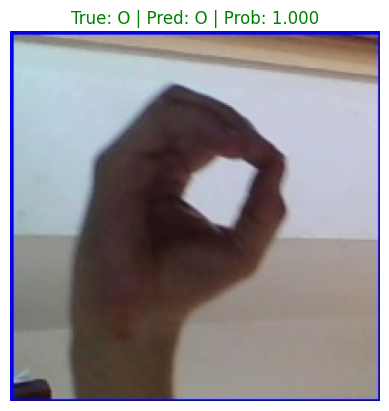

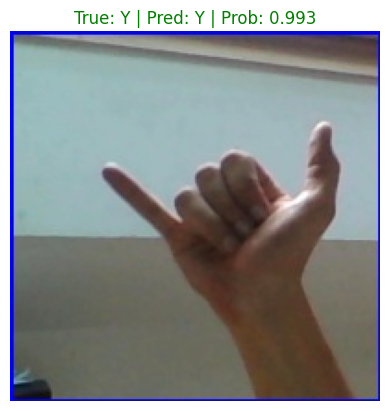

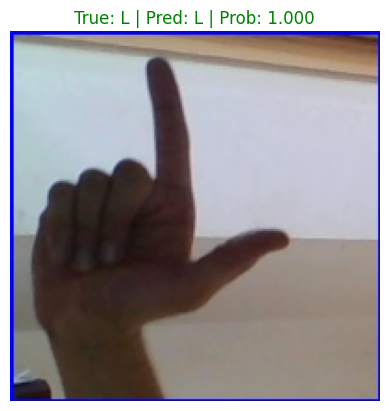

In [ ]:
import random
np.random.seed(42)
no_img_pred = 3
test_img_sample = random.sample(images.imgs, k=no_img_pred)

for image_path in test_img_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path[0],
                        class_names=class_names,
                        transform=transforms,
                        image_size=(224, 224))

The model is able to predict all the images accurately with almost 100% probability.

# Next

Next we'll deploy the model to a streamlit app.